# ***Numerov Method in solving the Schrodinger Equation***

In Sturm-Liouville eigenvalue problems, the form of equation that we are interested in is:
\begin{aligned} -\left(p\left(x\right)y'\left(x\right)\right)'+q\left(x\right)y\left(x\right)=\lambda r\left(x\right)y\left(x\right),\ 0<x<1 \end{aligned}

The one-dimensional Schrodinger Equation is:

\begin{aligned}
-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V(x)\psi(x) = E\psi(x)
\end{aligned}

Rewriting the above in Lagrange's Notation:
\begin{aligned} \psi''\left(x\right)+\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]\psi\left(x\right)=0 \end{aligned}

Comparing this with the Sturm-Liouville form, we identify:
\begin{aligned} p(x) = 1, \quad q(x) = \frac{2m}{\hbar^2}\left[E - V(x)\right], \quad r(x) = 1 \end{aligned}


To start off, we import the required libraries:

In [1]:
#*For any snippet of code that is similar in anyway, anywhere to anyone, the only source is from Bryan.*
# Importing required libraries
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Data manipulation
from scipy.optimize import fsolve, root_scalar  # Solving equations

# Customizing plot appearance
plt.rcParams['figure.figsize'] = [16, 10]  # Set figure size
plt.rcParams.update({'font.size': 16, 'axes.grid': True})  # Set font size and enable grid
# plt.style.use(['dark_background'])  # Uncomment for dark theme

## **1. Introduction using finite square potential well**

For simplicity's sake, we create the scenario for the finite square potential well and learn of the three regions of interest:

\begin{aligned}
E-V\left(x\right) &= 0 \\
E-V\left(x\right) &> 0 \\
E-V\left(x\right) &< 0 \\
\end{aligned}  \tag{1.1}

Note that we will only be considering bound states.

Let's plot the graph:

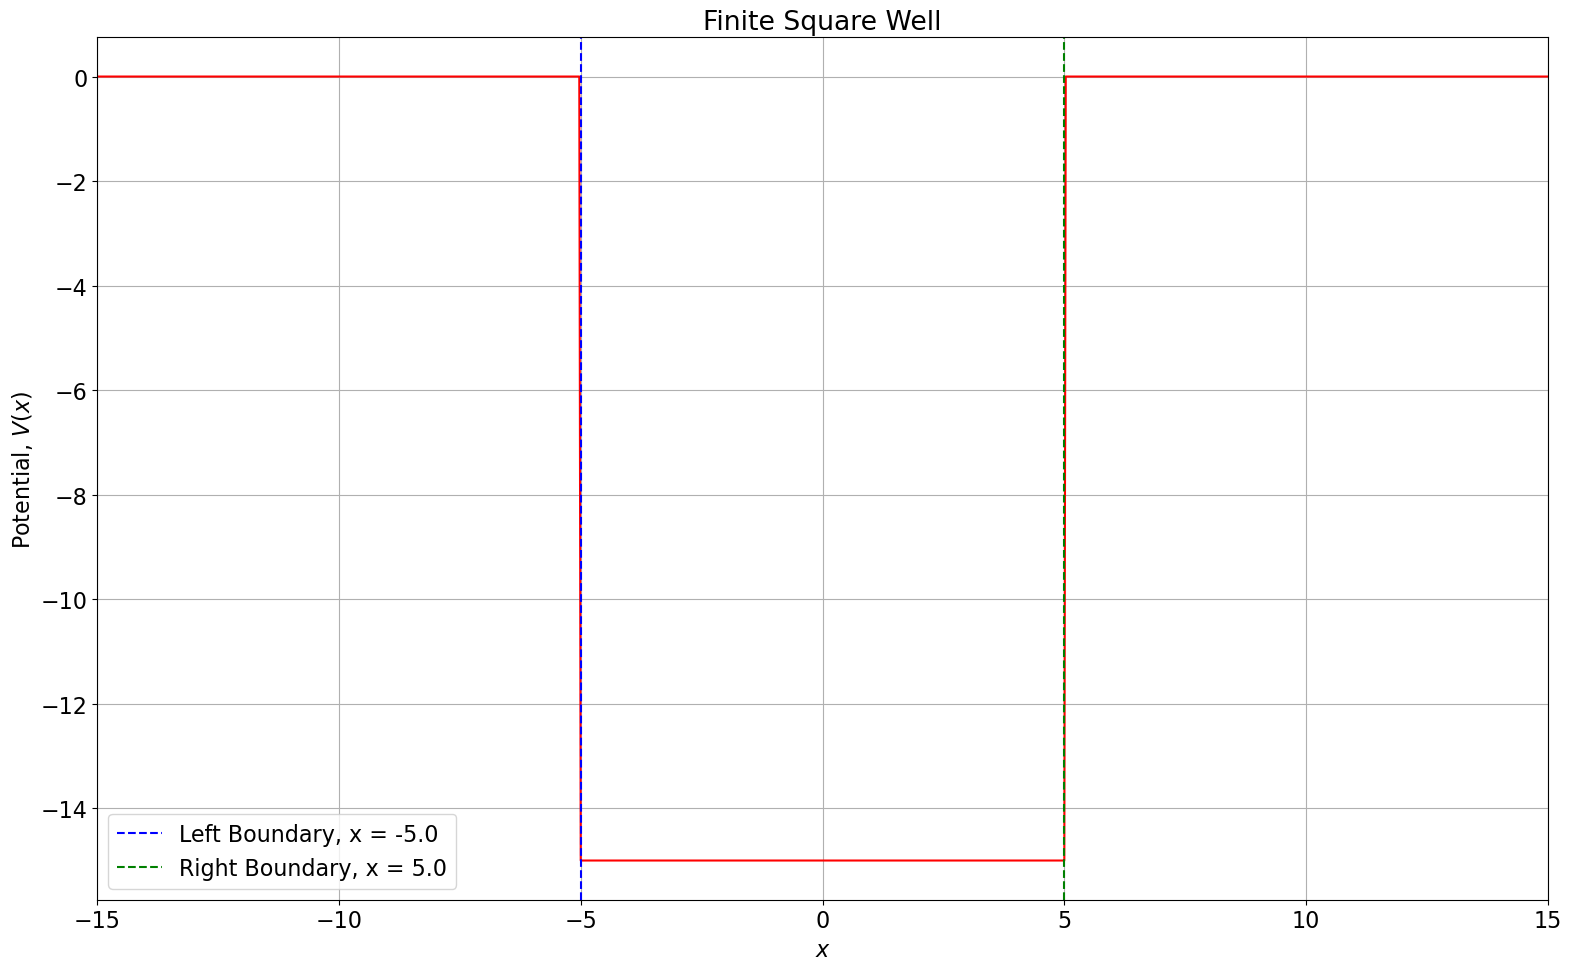

In [ ]:
# Boundaries of the well
a, b = -5.0, 5.0  # Left and right boundaries
h_0, h_1 = -15.0, 0.0  # Depth and height of the well

# Defining the symmetric potential well
def pot_well(x, a, b):
    return np.piecewise(x, [x < a, (x >= a) & (x <= b), x > b], [h_1, h_0, h_1])

# Calculate midpoint of the well and define x range
mid = (a + b) / 2
x = np.linspace(mid - 3 * np.abs(a), mid + 3 * np.abs(b), 1000)

# Plot the potential well
plt.plot(x, pot_well(x, a, b), color='red')
plt.axvline(x=a, color='blue', linestyle='--', label=f'Left Boundary, x = {a}')
plt.axvline(x=b, color='green', linestyle='--', label=f'Right Boundary, x = {b}')

plt.title('Finite Square Well')
plt.xlabel('$x$')
plt.xlim(mid - 3 * np.abs(a), mid + 3 * np.abs(b))
plt.ylabel('Potential, $V(x)$')
plt.legend()
plt.tight_layout()
plt.show()

For the region $x<-a=-5$ and $x>b=5$, where $E-V\left(x\right)<0$, the Schrodinger equation reads:

\begin{aligned} \psi''\left(x\right)=\frac{2m}{\hbar^2}\left[V\left(x\right)-E\right]\psi\left(x\right) \end{aligned}

The solution in these regions is:
\begin{aligned}
\psi_1(x)&=Ae^{\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x},\quad x<-a\\
\psi_3(x)&=Ae^{-\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, \quad x>b\\
\end{aligned}

For the middle region $\left(-a < x < b\right)$, where $E-V\left(x\right)>0$, we have the solution $\psi_2\left(x\right)=A\sin{(kx)}+B\cos{(kx)}, -a<x<b$,

where $k = \sqrt{\frac{2m(E - V(x))}{\hbar^2}}$.

Combining the solutions for all regions:
\begin{aligned}\psi\left(x\right)=\begin{cases}\psi_1(x)&=Ae^{\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x<-a\\
\psi_2\left(x\right)&=A\sin{(kx)}+B\cos{(kx)}, &&-a<x<b \\
\psi_3(x)&=Ae^{-\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x>b\end{cases}
\end{aligned}  \tag{1.2}

The factor determining the splitting of these regions is the condition $E-V\left(x\right) = 0$, which defines the **turning points**. 

1. The **first turning point** occurs at $x=-a$, where the particle transitions from the classically forbidden region $\left(E-V\left(x\right)<0\right)$ to the classically allowed region $\left(E-V\left(x\right)>0\right)$.
2. The **second turning point** occurs at $x=b$, where the particle transitions back to the classically forbidden region.

This behavior can also be observed by examining the intersections of the specified value of $E$ with the potential $V\left(x\right)$.

## **2. Numerical Methods in Solving the Schrodinger Equation** ##

However, when we are not capable of solving a potential analytically, we can implement numerical methods. Here we introduce the Numerov Method, which is an iteration method that gives error of 6th order $O\left(\delta x^6\right)$:

We have the Schrodinger Equation:
\begin{aligned}\psi''\left(x\right)+\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]\psi\left(x\right)&=0 \\
\psi''\left(x\right)&=-k^2\left(x\right)\psi\left(x\right)
\end{aligned}\tag{2.1}

where we absorbed $\begin{aligned} -\frac{2m}{\hbar^2}\end{aligned}\left[E-V\left(x\right)\right]$ into $k^2\left(x\right)$.

It should be noted that $E\ge V_0$, where $V_0$ is the minimum point of the potential, for the function to be normalised (See Griffiths 3rd Edition, Problem 2.2).

Discretising the variable, $x$, and applying the three point finite difference to approximate the second derivative:
\begin{aligned}\psi''\left(x\right)\approx\frac{\psi\left(x_{i+1}\right)-2\psi\left(x_{i}\right)+\psi\left(x_{i-1}\right)}{h^2}-\frac{h^2}{12}\psi^{\left(4\right)}\left(x\right)\end{aligned}\tag{2.2}

To improve our order of accuracy, we differentiate the Schrodinger Equation two more times, and substituting back in the finite difference formula:
\begin{aligned}\psi^{\left(4\right)}\left(x\right)=-\left(k^2\left(x\right)\psi\left(x\right)\right)'' \end{aligned}\tag{2.3}

From there, we obtain:
\begin{aligned}\psi''\left(x\right)\approx\frac{\psi\left(x_{i+1}\right)-2\psi\left(x_{i}\right)+\psi\left(x_{i-1}\right)}{h^2}+\frac{k^2\left(x_{i+1}\right)\psi\left(x_{i+1}\right)-2k^2\left(x_{i}\right)\psi\left(x_{i}\right)+k^2\left(x_{i-1}\right)\psi\left(x_{i-1}\right)}{12}\end{aligned}\tag{2.4}

Isolating the $\psi\left(x_{i+1}\right)$ term:
\begin{aligned}\boxed{\psi\left(x_{i+1}\right)=\frac{\psi\left(x_{i}\right)\left(2+\frac{5}{6}h^2k^2\left(x_{i}\right)\right)-\psi\left(x_{i-1}\right)\left(1-\frac{1}{12}h^2k^2\left(x_{i-1}\right)\right)}{1-\frac{1}{12}h^2k^2\left(x_{i+1}\right)}} \end{aligned}\tag{2.5}

For the iteration from the right, we isolate the $\psi\left(x_{i-1}\right)$ term:
\begin{aligned}\boxed{\psi\left(x_{i-1}\right)=\frac{\psi\left(x_{i}\right)\left(2+\frac{5}{6}h^2k^2\left(x_{i}\right)\right)-\psi\left(x_{i+1}\right)\left(1-\frac{1}{12}h^2k^2\left(x_{i+1}\right)\right)}{1-\frac{1}{12}h^2k^2\left(x_{i-1}\right)}} \end{aligned}\tag{2.6}

*Well, there's also a trick of iterating from the right (by reversing the initial and final points for np.linspace) which I will not be implementing here.*

Therefore, from the iteration formula, we require the first two points of the wavefunction. Fortunately, we can just set an arbitrary point, effectively far away from the region of the potential, and set it to be zero.

For the second point, we can just put an arbitrarily small number (say, $1\times 10^{-10}$) and iterate from there.

## **3. Continuity and Matching**

Apart from the continuity of the values of the functions at the turning points, we need to consider the continuity of the gradient for the iterations from both sides. If the chosen eigenvalue is correct, there should be no difference in the values of the function obtained at the turning points, $x_t$.

For the functions, the continuity conditions are:
\begin{aligned} \psi_l\left(x_t\right) &= \psi_r\left(x_t\right)
\\
\psi_l'\left(x_t\right) &= \psi_r'\left(x_t\right)
\end{aligned} \tag{3.1}

where subscripts $l$ and $r$ mean iteration from the left and from the right respectively.

Dividing the two equations, and applying the three point formula for the first derivative of $\psi$:
\begin{aligned} \frac{\left[\psi_l\left(x_t+h\right)-\psi_l\left(x_t-h\right)\right]}{2h\psi_l\left(x_t\right)}-\frac{\left[\psi_r\left(x_t+h\right)-\psi_r\left(x_t-h\right)\right]}{2h\psi_r\left(x_t\right)}=0 \end{aligned} \tag{3.2}

Therefore, we would like to find out what values of $E$ that will satisfy the above equation. If you haven't noticed, this is a root finding problem, which we can easily apply root-finding algorithms or built in functions.

We shall set the equation as $f\left(E\right)$, since we are only changing the value of $E$ and obtaining the value of the result (which is the difference in the iteration at a certain point). Again, if we have the correct value of $E$, the function must be zero.

\begin{aligned} f\left(E\right)=\frac{\left[\psi_l\left(x_t+h\right)-\psi_l\left(x_t-h\right)\right]}{2h\psi_l\left(x_t\right)}-\frac{\left[\psi_r\left(x_t+h\right)-\psi_r\left(x_t-h\right)\right]}{2h\psi_r\left(x_t\right)}=0 \end{aligned}  \tag{3.3}

## **4. Python code in Iterating the Wavefunction**

Now, we consider the following potential well, with a particle bound in it:

\begin{aligned}V\left(x\right)=\frac{\hbar^2}{2m}\alpha^2\lambda\left(\lambda-1\right)\left[\frac 1 2-\frac{1}{\cosh^2{\left(\alpha x\right)}}\right]\end{aligned}

where $\alpha$ and $\lambda$ are given parameters.

*If you're feeling fun, uncomment the part for the harmonic oscillator, the Eigenvalues are $\left(n+\frac {1} {2}\right)$*

The graph with $\alpha=1$ and $\lambda=4$ is as shown:

Plugging in the parameters:

In [ ]:
# Constants
hbar, m, alpha, lambda1 = 1.0, 1.0, 1.0, 4.0  # Physical constants
# omega = 1.0  # Uncomment for harmonic oscillator potential (if testing)

# Main definition of potential
def V(x):
    return (hbar ** 2 / (2 * m) * (alpha ** 2) * lambda1 * (lambda1 - 1) * (0.5 - 1 / (np.cosh(alpha * x)) ** 2))
    # Uncomment below for harmonic oscillator potential (if testing)
    # return 0.5 * m * omega ** 2 * x ** 2

Plotting of the potential,

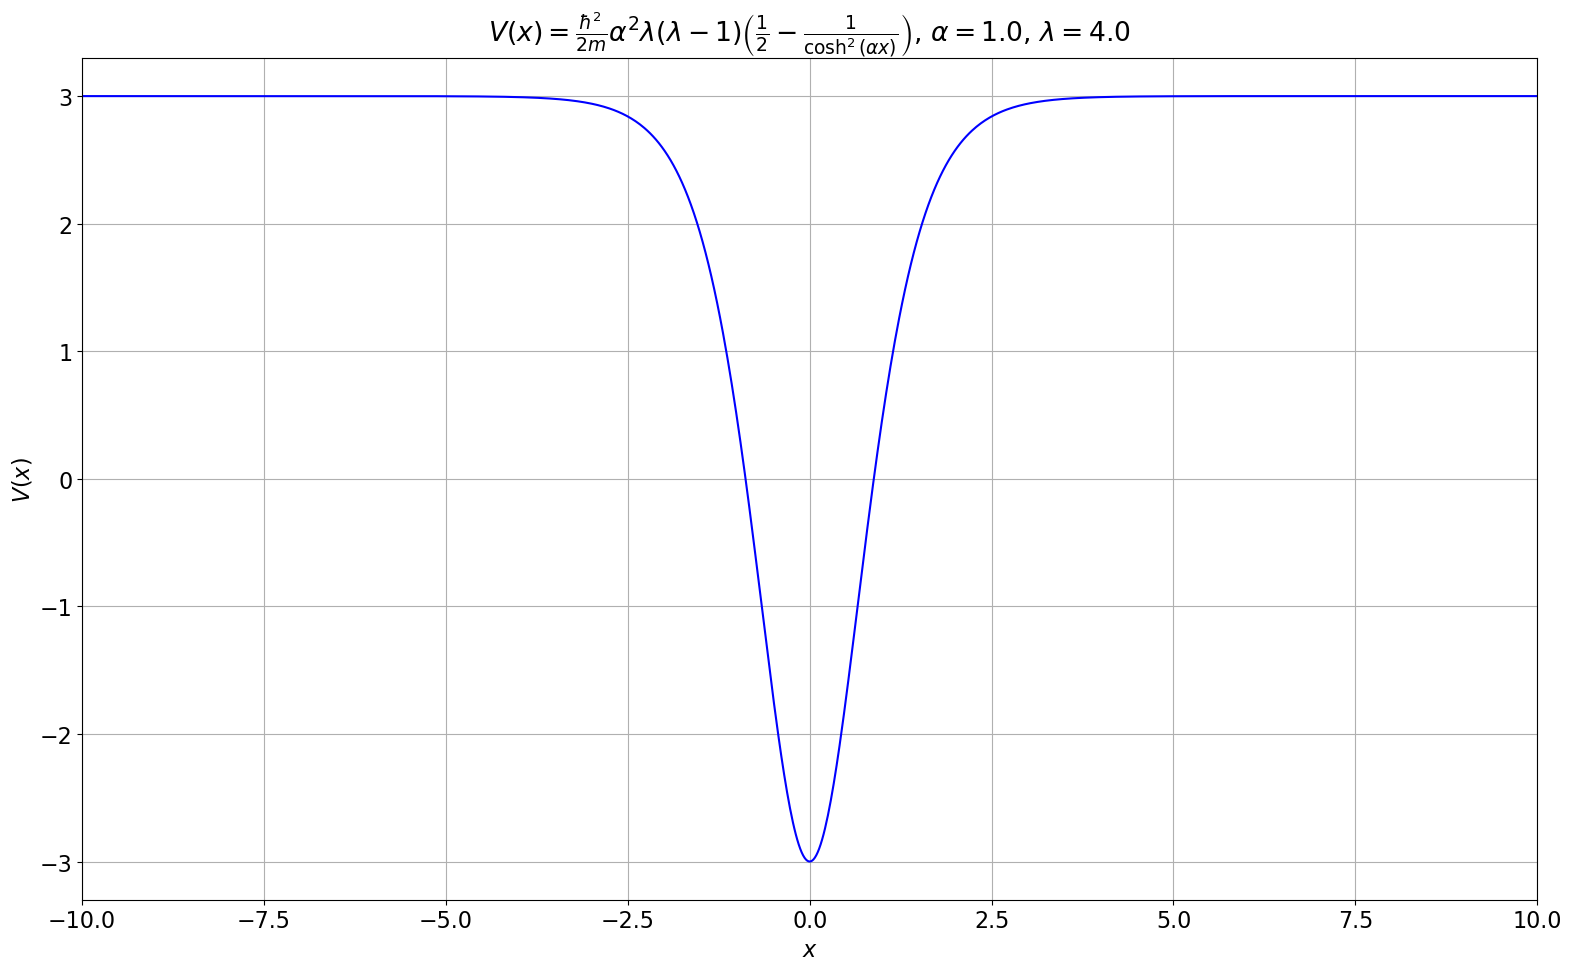

In [ ]:
# Define x values for plotting
x = np.linspace(-10 / alpha, 10 / alpha, 1000)

# Plot the potential V(x)
plt.plot(x, V(x), color='blue')
plt.xlim(-10 / alpha, 10 / alpha)
plt.title(rf'$V(x)=\frac{{\hbar^2}}{{2m}} \alpha^2 \lambda(\lambda-1)\left(\frac{{1}}{{2}}-\frac{{1}}{{\cosh^2(\alpha x)}}\right)$, $\alpha = {alpha}$, $\lambda = {lambda1}$')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.tight_layout()  # Ensures labels and titles fit properly
plt.show()

The given eigenvalues are in the form:

\begin{aligned}E_n=\frac{\hbar^2}{2m}\alpha^2\left[\frac{\lambda\left(\lambda-1\right)}{2}-\left(\lambda-1-n\right)^2\right], n = 0, 1, 2, 3, \dots \end{aligned}

with the first 10 eigenvalues as shown below:

   Eigenvalues
0         -1.5
1          1.0
2          2.5
3          3.0
4          2.5
5          1.0
6         -1.5
7         -5.0
8         -9.5
9        -15.0


Though we can continue printing the analytical eigenvalues, we should note that energy values outside the range of the potential $\left[-3, 3\right]$, exclusive the boundary points, does not constitute to an eigenvalue. This can be explained by the fact that there would be no intersection between the graphs $V=E\left(x\right)$ and $V=V\left(x\right)=\frac{\hbar^2}{2m}\alpha^2\lambda\left(\lambda-1\right)\left[\frac 1 2-\frac{1}{\cosh^2{\left(\alpha x\right)}}\right]$, for $\alpha = 1$ and $\lambda=4$.

First, we make a guess for the eigenvalues, $E$ (or just use the actual eigenvalue that we just computed, which i am going to do here):

In [ ]:
E_x = 2.5

The turning point is where $E=V(x)$.

To find the turning point, we use Bisection Method:

f(a=0) = 5.5, f(b=15.0) = -0.49999999999775424
Approximate left root: -1.9140842356665502
Approximate right root: 1.9140842356665502
Number of iterations: 54


Therefore the root is found by bisection method. Note that the trick of multiplying a negative sign on the root we found is only valid for symmetric potentials, mirrored at $x=0$.

For a much simpler method of finding the root, we use the built in fsolve function:

In [ ]:
# Define the function for solving (E - V(x))
def g(x):
    return E_x - V(x)

# Use fsolve to find the root
aroot = fsolve(g, -1) # Initial guess of -1
print("Root found by fsolve:", aroot[0])

Root found by fsolve: -1.9140842356665437


Which proves that the code for Bisection Method is doing its work.

Now we set the boundaries of the plot. We set the leftmost and rightmost boundaries to be effectively far away from the potential. In this code, the boundaries depend on the width of the roots.

We also set the values of the wavefunction at the two endpoints to be zero, as a starting point.

The roots are our turning points. Based on the value of the roots,  we plot for the intersection of $V=E$ and $V=V\left(x\right)$:

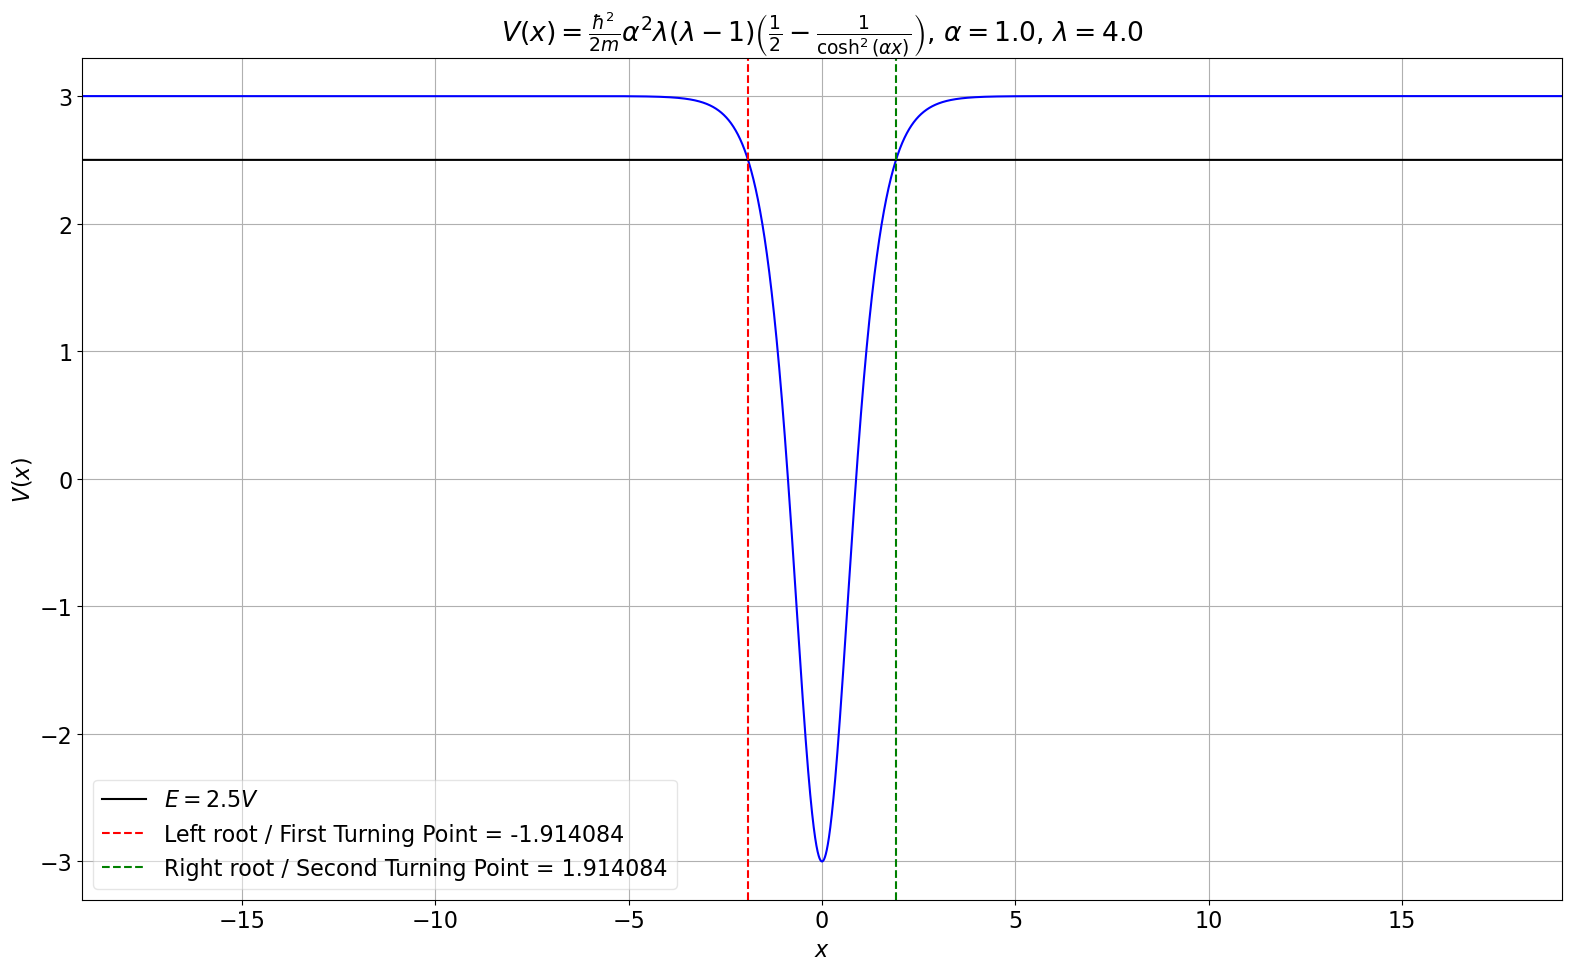

Checking the values of the graph (Remove the #print(df)):

Now it's time for us to iterate the function. First, we iterate from the left boundary to the first turning point, checking the values of the wavefunction along the way:

In [ ]:
# optional printing

Left Boundary
Point 0: x = -19.1408423566655, y = 0.0
Point 1: x = -19.138928272429837, y = 1e-10
Point 2: x = -19.13701418819417, y = 2.0000036637195797e-10
---------------------------------------
1st Turning Point
Point 9001: x = -1.9121701514308835, y = 0.6950049106334422
Point 9000: x = -1.9140842356665502, y = 0.6940288224284394
Point 8999: x = -1.9159983199022186, y = 0.6930527342185351
---------------------------------------


Also iterating from the right boundary to the second turning point:

In [ ]:
# optional printing

2nd Turning Point
Point -1: x = 1.9121701514308835, y = 0.6950049106334422
Point 0: x = 1.9140842356665502, y = 0.6940288224284394
Point 1: x = 1.9159983199022166, y = 0.6930527342185351
---------------------------------------
Right Boundary
Point 9000: x = 19.1408423566655, 0.0
Point 8999: x = 19.138928272429837, 1e-10
Point 8998: x = 19.137014188194165, 2.0000036637195797e-10
---------------------------------------


From the above, we see that the values of graphs around the turning points are symmetric at $x=0$. That is a good sign that our iteration is correct.

Plotting from left boundary, to the second turning point; and from right boundary, to the first turning point (This is to check the overlapping for the oscillatory region):

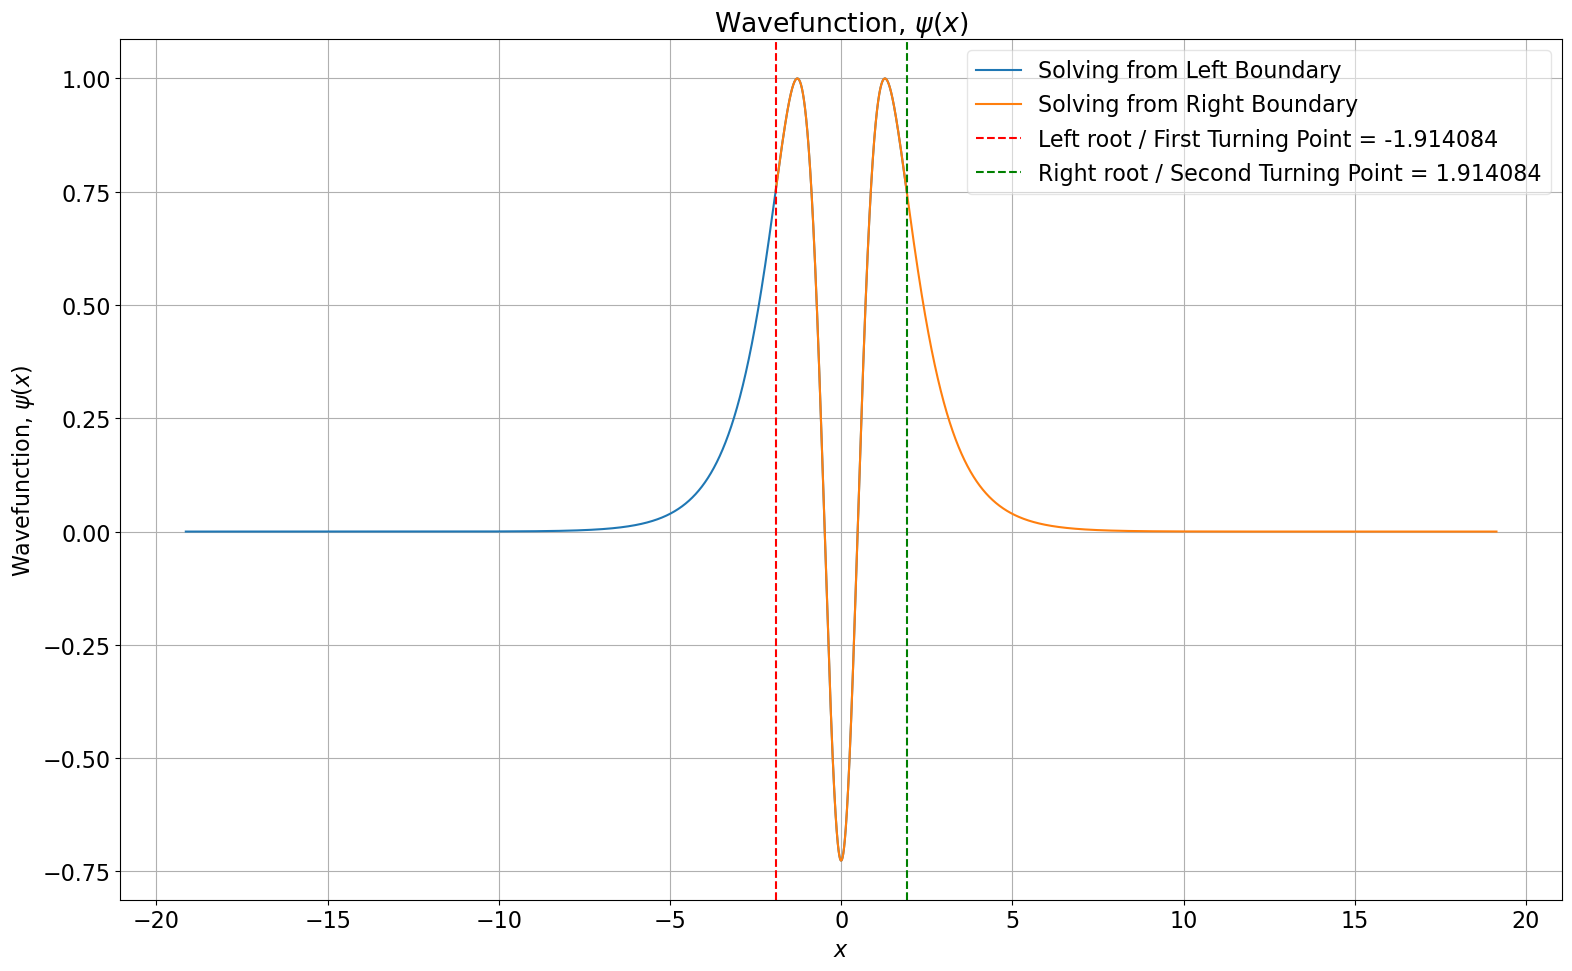

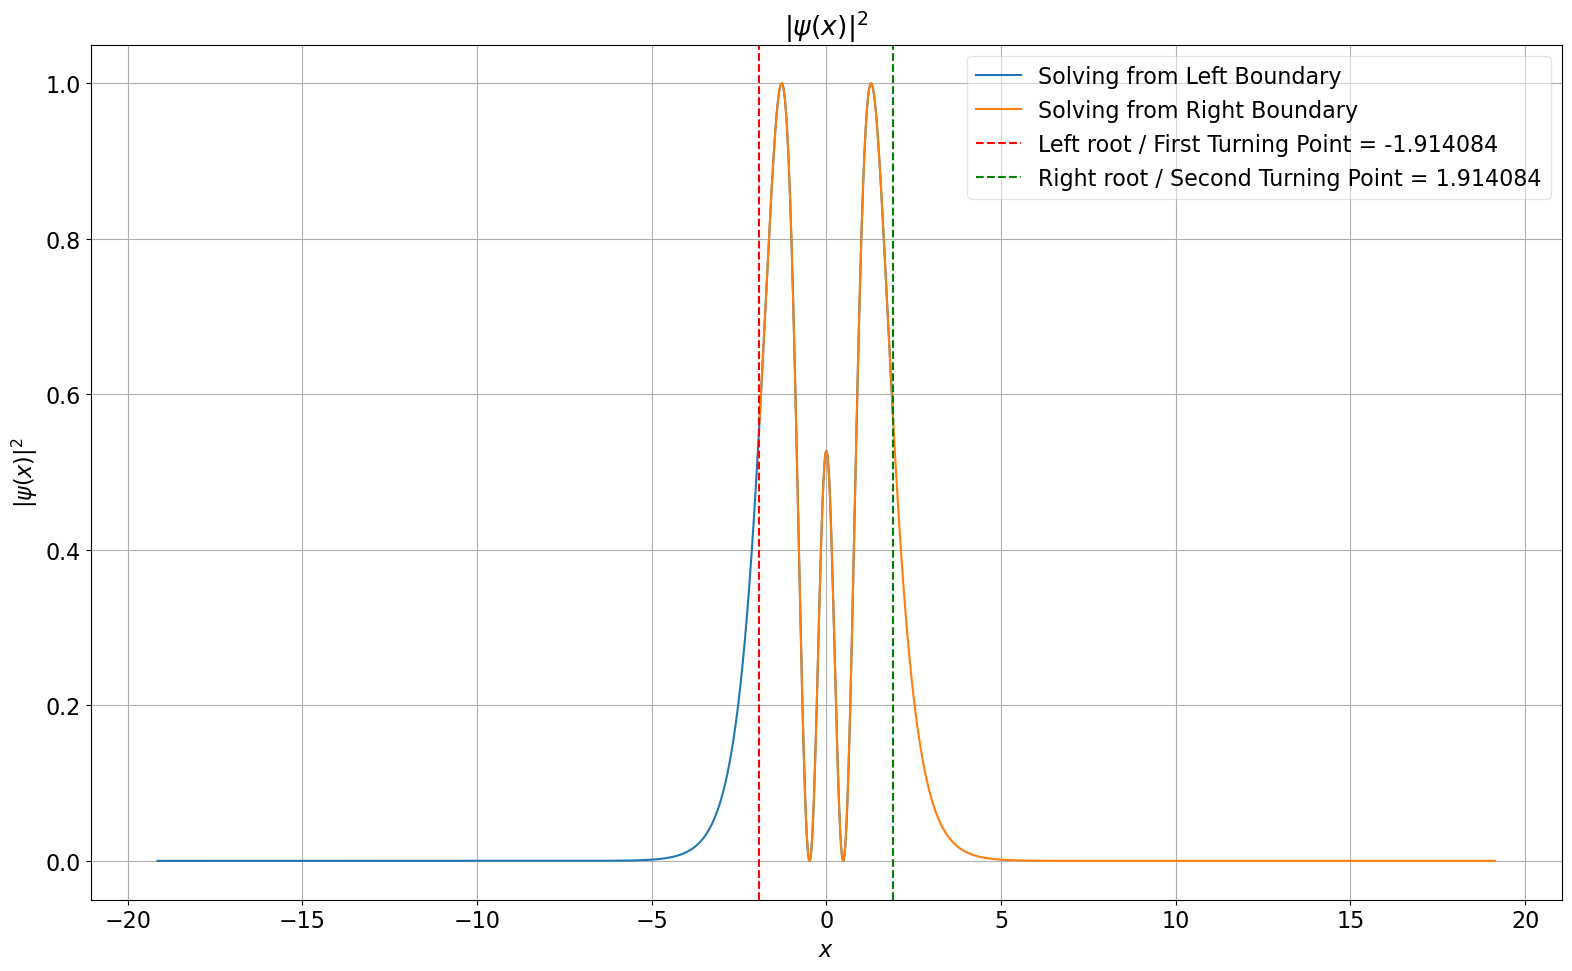

In [ ]:
# second graph is optional

As shown above, at the correct energy values, the shooting from the left aligns perfectly with the shooting from the right. This explains why only specific $E$ values are valid. For energy values other than the eigenvalues, the wavefunction will not decay to zero on both sides of the turning point. As a proof to the statement above, let us try, for $E=2.501V$:

But before that, we also compute the function below:

\begin{aligned} f\left(E\right)=\frac{\left[\psi_l\left(x_t+h\right)-\psi_l\left(x_t-h\right)\right]}{2h\psi_l\left(x_t\right)}-\frac{\left[\psi_r\left(x_t+h\right)-\psi_r\left(x_t-h\right)\right]}{2h\psi_r\left(x_t\right)}=0 \end{aligned}

You can use the one in the pdf from class, the original equation. But you'll get more things from this notebook.

We take the first turning point as our reference.

f(2.501)= -0.010022401851287666


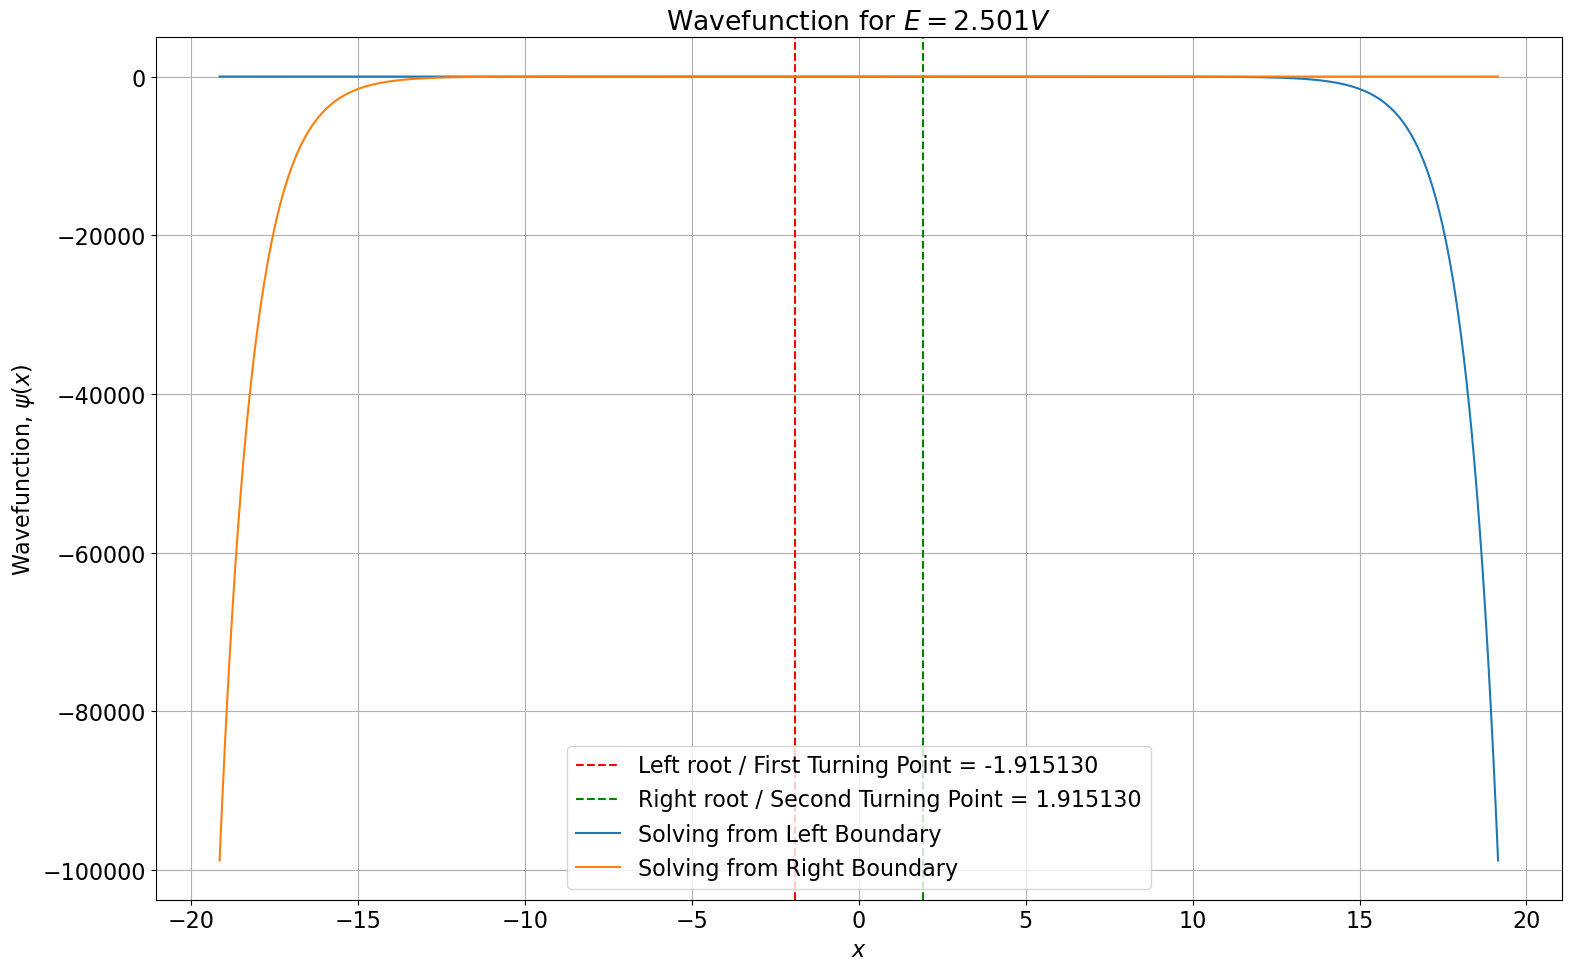

In [ ]:
# graph is optional

As shown above, the wavefunction is not tame at regions outside the well, they are exponentially decreasing (for this case). This is always the case for the wrong values of $E$. 

As seen from the last few lines, I can just change the values of $E$ and check for the value of the $f\left(E\right)$. In the case for $E=2.5 V$, the value of $f\left(E\right)$ at that point is effectively close to zero, which means that one of the eigenvalues is $2.5 V$ (do check by changing the value!). You may check for other values of $E$, to try to guess the other eigenvalues. However, we are going to use a root-finding algorithm to get the other eigenvalues.

Having obtained the function of $f\left(E\right)$, we implement a scanning method:

1. **Define the domain:** The scanning range is set (for this case $-2.99V$ to $2.99V$), with the spacing set ($E_1, E_2, \dots, E_n$).
2. **Evaluating the function:** The program computes the values of $f\left(E\right)$ for two consecutive points, $f\left(E_i\right)$ and $f\left(E_{i+1}\right)$.
3. **Identifying sign changes and compute roots:** If $f\left(E_i\right)$ and $f\left(E_{i+1}\right)$ have opposite signs, the program does a root-finding algorithm and returns the root between these points.

This program is quite expensive computationally, so be prepared to wait for up to a minute.

Root found in interval [-1.514, -1.489], with their values being 0.067971 and -0.058065
Root found in interval [-0.988, -0.963], with their values being -143.820721 and 77.336693
Root found in interval [0.988, 1.013], with their values being 0.081556 and -0.099622
Root found in interval [1.314, 1.339], with their values being -45.097866 and 64.166356
Root found in interval [2.490, 2.515], with their values being 0.098690 and -0.158165
Root found in interval [2.640, 2.665], with their values being -14.291186 and 15.429117
Roots: [-1.5        -0.97981698  1.          1.32789668  2.5         2.6519203 ]


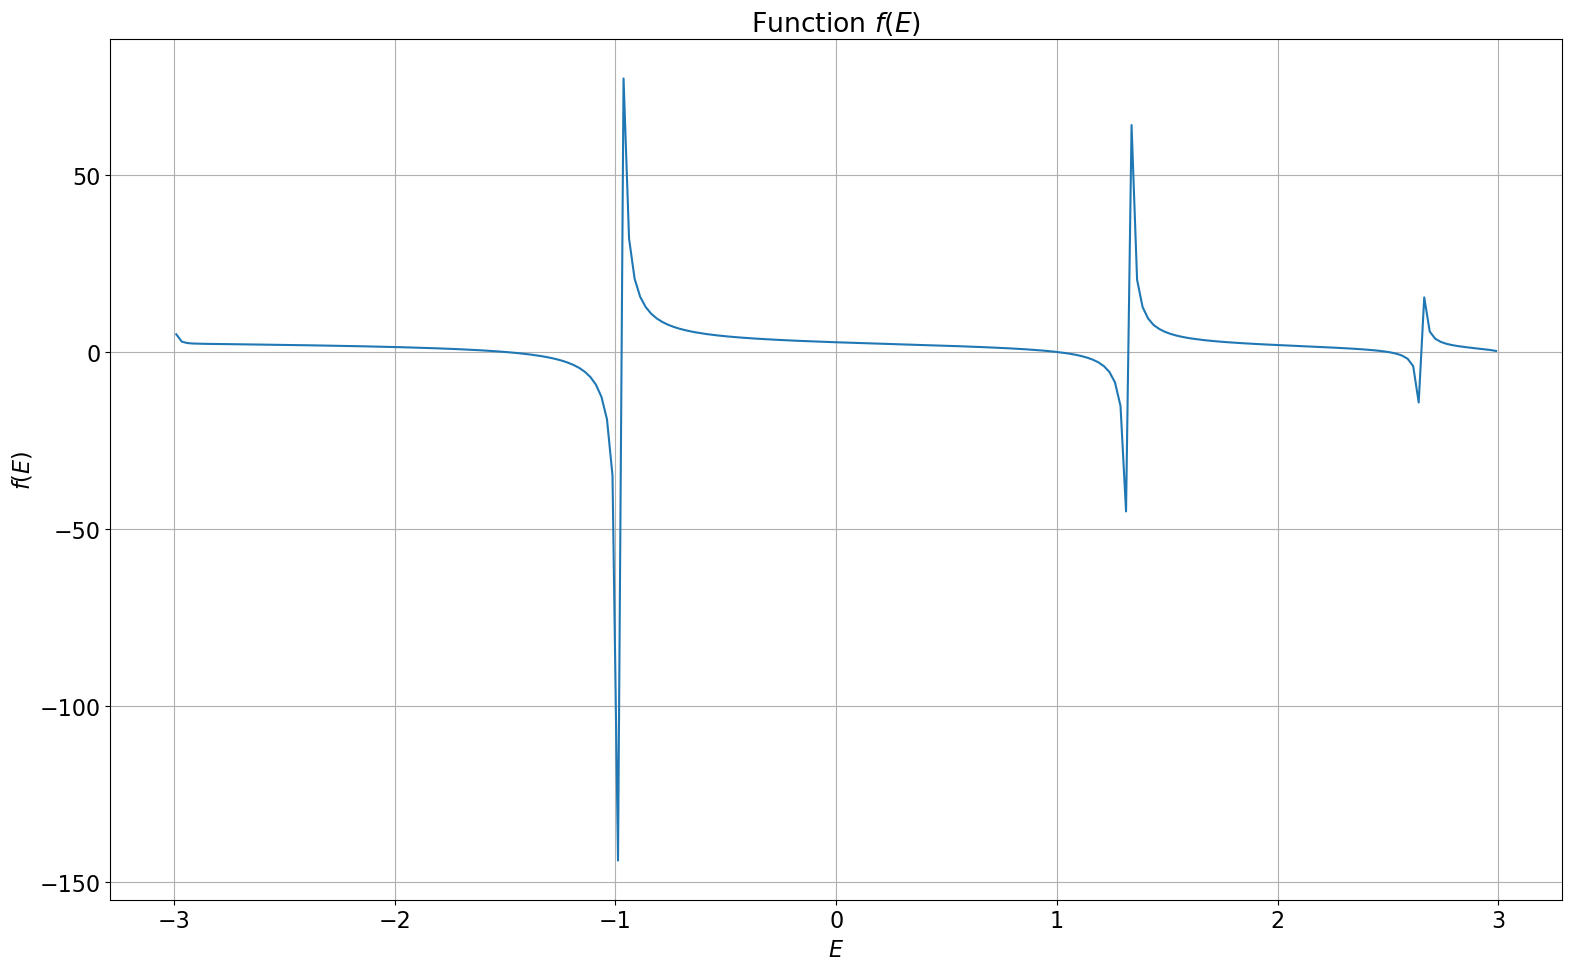

In [ ]:
# graph is optional

Well, from the graph, we can see that the "roots" obtained by the code has some 'weird' asymptotic lines. These points are considered as an asymptote, and will not be included as the root.

Let's look at the graph around $E=-1V$. The program identifies a root near that asymptote because the function's sign changes as it crosses the asymptote. Since the plot connects computed points with lines, a line will inevitably cross zero when the sign switches. This effect is amplified by the small spacing of $E$ in $f\left(E\right)$.

Therefore, the only valis roots are $-1.5V$, $1.0V$ and $2.5V$, aligned with the analytical eigenvalues. It corresponds to the exact expression for $n=0, 1, 2, 4, 5, 6$ (for the exact eigenvalue function we did early on).

I hope this code is packed with enough information for you to understand my flow of thoughts, that is it then!